In [1]:
import numpy as np
import pandas as pd
import datetime

import seaborn as sns


In [2]:
main_df = pd.read_csv('Candidate_tech_evaluation_candidate_copy_data science_fraud.csv', index_col = 0).reset_index(drop=True)
ip_df = pd.read_csv('Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.csv')
test_df = pd.read_csv('fraud_holdout_no_label.csv', index_col = 0).reset_index(drop=True)

In [3]:
main_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [4]:
# main_df.info()

### Preprocessing

In [5]:
# function for ip address --> country
def ip_country_func(ip_val):
    result = ip_df.loc[(ip_df['lower_bound_ip_address'] <= ip_val) & (ip_df['upper_bound_ip_address'] >= ip_val), 'country'].values
    
    if len(result) > 0:
        return result[0]
    else:
        return 'unknown'

# function for getting month, day, hour, the day of week
def dayofweek(value):
    return value.weekday()

def get_month(value):
    return value.month

def get_date(value):
    return value.day

def get_hour(value):
    return value.hour

def preprocess_df(df):
    # change ip address to country
    df['country'] = df['ip_address'].apply(ip_country_func)

    # make signup_time and puchase_time to datetime format
    df['signup_time_new'] = pd.to_datetime(df['signup_time'])
    df['purchase_time_new'] = pd.to_datetime(df['purchase_time'])

    # calculate how much time it took to make the purchase
    df['time_diff'] = df['purchase_time_new'] - df['signup_time_new']

    # extract month, date, the day of week, hour from 2 columns
    df['signup_day'] = df['signup_time_new'].apply(dayofweek)
    df['purchase_day'] = df['purchase_time_new'].apply(dayofweek)

    df['signup_month'] = df['signup_time_new'].apply(get_month)
    df['purchase_month'] = df['purchase_time_new'].apply(get_month)

    df['signup_date'] = df['signup_time_new'].apply(get_date)
    df['purchase_date'] = df['purchase_time_new'].apply(get_date)

    df['signup_hour'] = df['signup_time_new'].apply(get_hour)
    df['purchase_hour'] = df['purchase_time_new'].apply(get_hour)
    
    return df

In [6]:
main_df = preprocess_df(main_df)
test_df = preprocess_df(test_df)

### EDA

In [7]:
main_df.describe()

,user_id,purchase_value,age,ip_address,class,signup_time_new,purchase_time_new,time_diff,signup_day,purchase_day,signup_month,purchase_month,signup_date,purchase_date,signup_hour,purchase_hour
count,120000.000000,120000.000000,120000.000000,1.200000e+05,120000.000000,120000,120000,120000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.00000,120000.000000,120000.000000
mean,200320.280100,36.881475,33.125250,2.151550e+09,0.093875,2015-04-20 02:44:56.677499904,2015-06-16 05:03:28.336000,57 days 02:18:31.658500,3.023633,3.016808,4.150333,6.010742,14.724525,15.30350,11.502325,11.512183
min,2.000000,9.000000,18.000000,9.344714e+04,0.000000,2015-01-01 00:00:00,2015-01-01 00:00:00,0 days 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000
25%,100925.500000,22.000000,27.000000,1.085345e+09,0.000000,2015-02-18 15:15:45,2015-04-18 15:48:00,25 days 07:49:00,1.000000,1.000000,2.000000,4.000000,7.000000,8.00000,6.000000,6.000000
50%,200037.500000,34.000000,33.000000,2.155238e+09,0.000000,2015-04-19 05:40:00,2015-06-18 15:45:00,56 days 23:53:00,3.000000,3.000000,4.000000,6.000000,14.000000,15.00000,12.000000,12.000000
75%,300395.500000,49.000000,39.000000,3.241268e+09,0.000000,2015-06-18 14:38:00,2015-08-17 19:33:00,88 days 12:30:15,5.000000,5.000000,6.000000,8.000000,22.000000,23.00000,17.000000,17.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000,2015-08-18 04:31:00,2015-12-16 02:56:00,119 days 23:59:00,6.000000,6.000000,8.000000,12.000000,31.000000,31.00000,23.000000,23.000000
std,115361.945935,18.325855,8.617081,1.248314e+09,0.291656,NaN,NaN,36 days 04:49:43.973990713,2.006533,2.006733,2.255525,2.659662,8.733310,8.81264,6.913481,6.915225


<Axes: xlabel='browser', ylabel='class'>

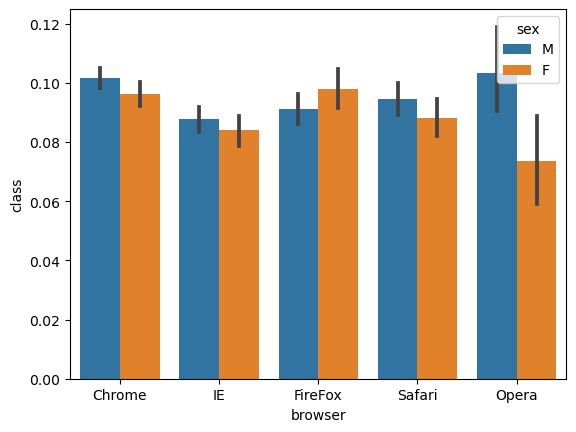

In [8]:
sns.barplot(x='browser', y='class', hue='sex', data=main_df)

<Axes: xlabel='source', ylabel='class'>

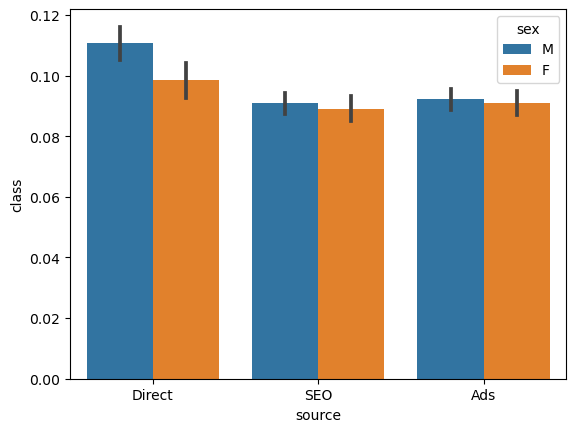

In [9]:
sns.barplot(x='source', y='class', hue='sex', data=main_df)

<Axes: xlabel='purchase_day', ylabel='class'>

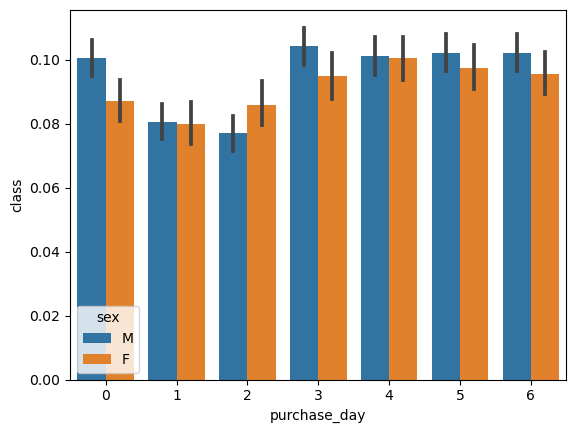

In [10]:
sns.barplot(x='purchase_day', y='class', hue='sex', data=main_df)

<Axes: xlabel='signup_day', ylabel='class'>

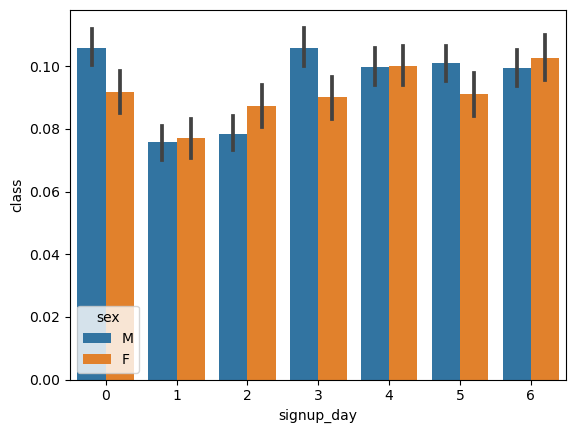

In [11]:
sns.barplot(x='signup_day', y='class', hue='sex', data=main_df)

In [12]:
# there may be no significant difference of purchase value between fraud vs non-fraud
print('fraud & purchase value distribution')
print(main_df.loc[main_df['class'] == 1, 'purchase_value'].describe())
print('*' * 30)
print('*' * 30)
print('non-fraud & purchase value distribution')
print(main_df.loc[main_df['class'] == 0, 'purchase_value'].describe())

fraud & purchase value distribution
count    11265.000000
mean        37.066134
std         18.428676
min          9.000000
25%         22.000000
50%         35.000000
75%         49.000000
max        111.000000
Name: purchase_value, dtype: float64
******************************
******************************
non-fraud & purchase value distribution
count    108735.000000
mean         36.862344
std          18.315148
min           9.000000
25%          22.000000
50%          34.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64


### Preprocessing

In [13]:
# label 분리하기

label = main_df['class']

cat_columns = ['source', 'browser', 'country', 'signup_day', 'purchase_day', 'signup_month', 'purchase_month', 'signup_date', 'purchase_date', 'signup_hour', 'purchase_hour']
num_columns = ['purchase_value', 'age']
feature_columns = cat_columns +  num_columns

In [14]:
train = main_df[feature_columns]
x_test = test_df[feature_columns]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

x_train, x_valid, y_train, y_valid = train_test_split(train, label, 
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True,
                                                      stratify=label)

x_train_original = x_train.copy()

list_tmp = [x_train, x_valid, y_train, y_valid]
for i in list_tmp:
    i.reset_index(drop=True, inplace = True)
    print(i.shape)

(96000, 13)
(24000, 13)
(96000,)
(24000,)


In [16]:
# encoding the label
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

print(le.classes_)

[0 1]


In [17]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

x_train[num_columns] = stdscaler.fit_transform(x_train[num_columns])
x_valid[num_columns] = stdscaler.transform(x_valid[num_columns])
x_test[num_columns] = stdscaler.transform(x_test[num_columns])

C:\Users\USER\AppData\Local\Temp\ipykernel_33160\3729222614.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[num_columns] = stdscaler.transform(x_test[num_columns])


In [18]:
def ohe_encoding(tmp_x_train, tmp_x_valid, tmp_x_test):
    
    # encoding
    ohe = OneHotEncoder(sparse_output=False, feature_name_combiner='concat')

    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_valid[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    ohe.fit(x_all)
    
    ohe_columns = ohe.get_feature_names_out()
    
    # cat df ohe convert
    new_x_train_cat = pd.DataFrame(ohe.transform(tmp_x_train[cat_columns]), columns= ohe_columns)
    new_x_valid_cat = pd.DataFrame(ohe.transform(tmp_x_valid[cat_columns]), columns= ohe_columns)
    new_x_test_cat =  pd.DataFrame(ohe.transform(tmp_x_test[cat_columns]), columns= ohe_columns)
    
    # drop the original features
    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_valid = tmp_x_valid.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)
    
    # num cat df concat
    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_valid = pd.concat([tmp_x_valid, new_x_valid_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_valid, tmp_x_test

In [19]:
x_train, x_valid, x_test = ohe_encoding(x_train, x_valid, x_test) 

### Making Prediction

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(solver='liblinear')


model_list = [lr_clf]

In [21]:
# x_train, x_valid, y_train, y_valid 

def get_clf_eval(y_valid, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_valid , pred)
    precision = precision_score(y_valid , pred, average='macro') # average를 반드시 정의해줘야 함
    recall = recall_score(y_valid , pred, average='macro')
    f1 = f1_score(y_valid, pred, average='macro')

    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [22]:
# I tried to define my own loss function based on the question, but it seems when you define 
# the loss function as below, due to the imbalanced data, the model tries to predict everythin in 0

def loss_fn(y_true,y_pred):
    loss_score = 0
    N = len(y_true)
    
    for i in range(N):
        if y_true[i] != y_pred[i]:
            if (int(y_true[i]) == 1) and (int(y_pred[i]) == 0):
                loss_score += x_train_original['purchase_value'][i] 
            elif (int(y_true[i]) == 0) and (int(y_pred[i]) == 1):
                loss_score += 8 ####
                
    return (1-1/loss_score)

In [23]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5],
             'min_samples_split':[2,3], 'min_samples_leaf':[1,5]}

custom_scorer = make_scorer(loss_fn)

grid_dclf = GridSearchCV(rf_clf, param_grid=parameters, scoring='custom_scorer', cv=4)
grid_dclf.fit(x_train, y_train)

print('GridSearchCV best hyperparameter :', grid_dclf.best_params_)
print('GridSearchCV best precision: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(x_valid)

GridSearchCV best hyperparameter : {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV best precision: 0.9061


In [24]:
print('model: ', rf_clf)
get_clf_eval(y_valid, dpredictions)

model:  RandomForestClassifier(random_state=11)
accuracy: 0.9061, precision: 0.4531, recall: 0.5000, F1: 0.4754


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### get the final answer

In [25]:
final_prediction = best_dclf.predict(x_test)

answer_df = pd.read_csv('fraud_holdout_no_label.csv', index_col = 0).reset_index(drop=True)
answer_df['label'] = final_prediction


In [29]:
answer_df.to_csv('answer_df.csv') # index=False?